In [2]:
# if no output is shown,
#   1. Open cmd or powershell terminal
#   2. Activate a conda environment running py 3.10.8+ (venv/conda optional but recommended)
#   3. cd to the directory containing THIS file, probably wherever you cloned the repo to. 
#   3. in your terminal run the following command(s): 
#       py -m pip install -r requirements.txt

#   If no errors, you should be able to run this file in a jupyter notebook or jupyter lab instance. End goal is to have a web app that can be run from a browser.. but that's a ways off.

#### TODO: remove collections from requirements.txt, it's not used in this file and throws an error when installing.

In [3]:
# General Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load                                                   ### REPLACE WITH GIT LINK -- CHECK BRANCH BEFORE RUNNING !!!###
# https://github.com/ttatum742/OSHAintern/blob/v0.1.2/data/reform.csv?raw=true
df = pd.read_csv('https://github.com/ttatum742/OSHAintern/blob/v0.1.2/data/reform.csv?raw=true')

In [4]:

## Specifying data pars
# df = df[df['State']=='TX']

# ## Processing
# # Drop Unwanted
# df.drop(["0","UPA","Address1","Address2","Inspection",
#          "Nature","Part of Body","Event","Source","Secondary Source"],axis=1,inplace=True)

# # Change Dtypes
# df.Hospitalized = df.Hospitalized.astype(int)
# df.Amputation= df.Amputation.fillna(0).astype(int)
df['EventDate'] = pd.to_datetime(df["EventDate"])

# Capitalize Category Values
for x in ["City","State"]:
    df[x] = df[x].str.capitalize()

# Clean Employer Variable
df["Employer"] = df["Employer"].str.capitalize().str.replace('[^\w\s]','')
df.loc[df.Employer.str.contains(r"(?i)Postal Service|(?i)States Postal|(?i)USPS"),"Employer"] = "US postal service"
df.loc[df.Employer.str.contains(r"\b(?i)ups\b"),"Employer"] = 'United parcel service'
# Remove company type from name.
df["Employer"] = df.Employer.str.replace(r"\binc\b|\bllc\b|\blde\b|\bco\b|\bcorp\b|\bllp\b", '').str.strip()

"""

Regular Expression Explanation:
- [^\w\s] : [^] Negatve Set \w Words \s White Spaces
- (?i)ups : Removes case sensitivity from ups -> UPS, UPs, ups etc. would be returned
- r"\bups\b" : In this case "ups" will only be returned if it borders (b) a non-letter. e.i its a exact word.
- | : Represents "or" argument


"""
# USE THE CODE BELOW TO MAKE AMPUTATION VARIABLE FROM EVENT DESC
# df["Amputation"] = df["EventDesc"].str.contains("amputation", case=False).astype(int)

# New Gender Variables
df["Male"] = False
df["Female"] = False

# True when gender pronoun appears
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\\b|(?i)\bhe\b|(?i)\bmale\b|(?i)\bhim\b'),["Male"]] = True
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\\b|(?i)\bshe\b|(?i)\bfemale\b|(?i)\bher\b'),["Female"]] = True

# Gender Var
df["Gender"] = "NULL"
df.loc[(df.Male == True),"Gender"] = "Male"
df.loc[(df.Female == True),"Gender"] = "Female"
df.loc[(df.Female == True)&(df.Male == True),"Gender"] = "Both Mentioned"


In [5]:

"""
Hospitalized/Amputated - Binary Variable

"""

# Fast funcdtion for top occruence categories
def topcat_index(series, n=5):
    """
    Returns the top n categories in a series
    """
    return series.value_counts().index[:n]
def topcats(series, n=5):
    return series.isin(topcat_index(series, n=n))


# ## New Amputation Variable
# df["Amputated"]= False
# df.loc[df["Amputation"] > 0,"Amputated"] = True

# # New Hospital
# df["Hospital"]= False
# df.loc[df["Hospitalized"] > 0,"Hospital"] = True

print("Pre-Processing Complete")



Pre-Processing Complete


In [6]:

for x in ["Male","Female","Gender"]:
    print("\n{}:\n".format(x))
    print(df[x].value_counts())
    print(df[x].value_counts(normalize=True))

print("\n{} % o both gender pronouns are precent".format(
    round((df[(df.Male == True) & (df.Female == True)].shape[0]/df.shape[0])*100,2)))


Male:

False    106477
True      18904
Name: Male, dtype: int64
False    0.849228
True     0.150772
Name: Male, dtype: float64

Female:

False    119537
True       5844
Name: Female, dtype: int64
False    0.95339
True     0.04661
Name: Female, dtype: float64

Gender:

NULL              100674
Male               18863
Female              5803
Both Mentioned        41
Name: Gender, dtype: int64
NULL              0.802945
Male              0.150445
Female            0.046283
Both Mentioned    0.000327
Name: Gender, dtype: float64

0.03 % o both gender pronouns are precent


In [7]:
def custom_describe(df):
    """
  
    """
    unique_count = []
    for x in df.columns:
        mode = df[x].mode().iloc[0]
        unique_count.append([x,
                             len(df[x].unique()),
                             df[x].isnull().sum(),
                             mode,
                             df[x][df[x]==mode].count(),
                             df[x].dtypes])
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
    return pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T

custom_describe(df)

Dataframe Dimension: 125381 Rows, 18 Columns


Column,Unnamed: 0,UPA,EventDate,EventTitle,Final Narrative,Part of Body Title,NatureTitle,SourceTitle,degree,City,State,Employer,Primary NAICS,Amputation,Hospitalized,Male,Female,Gender
Unique,125381,119775,45082,366,112076,155,213,1121,3,10779,108,80682,2412,1,1,2,2,4
Missing,0,0,0,0,0,0,0,0,0,16,0,0,2,0,0,0,0,0
Mode,0,201923414,2005-03-23 13:15:00,Struck By,Employee Is Injured in Fall from Ladder,Fingertip(s),Fractures,Machine,Hospitalized,Houston,Ca,US postal service,238160.0,0,0,False,False,NULL
Mode Occurence,1,104,135,12655,284,8634,23401,8004,83772,1603,22903,1160,1684,125381,125381,106477,119537,100674
dtype,int64,int64,datetime64[ns],object,object,object,object,object,object,object,object,object,object,int64,int64,bool,bool,object


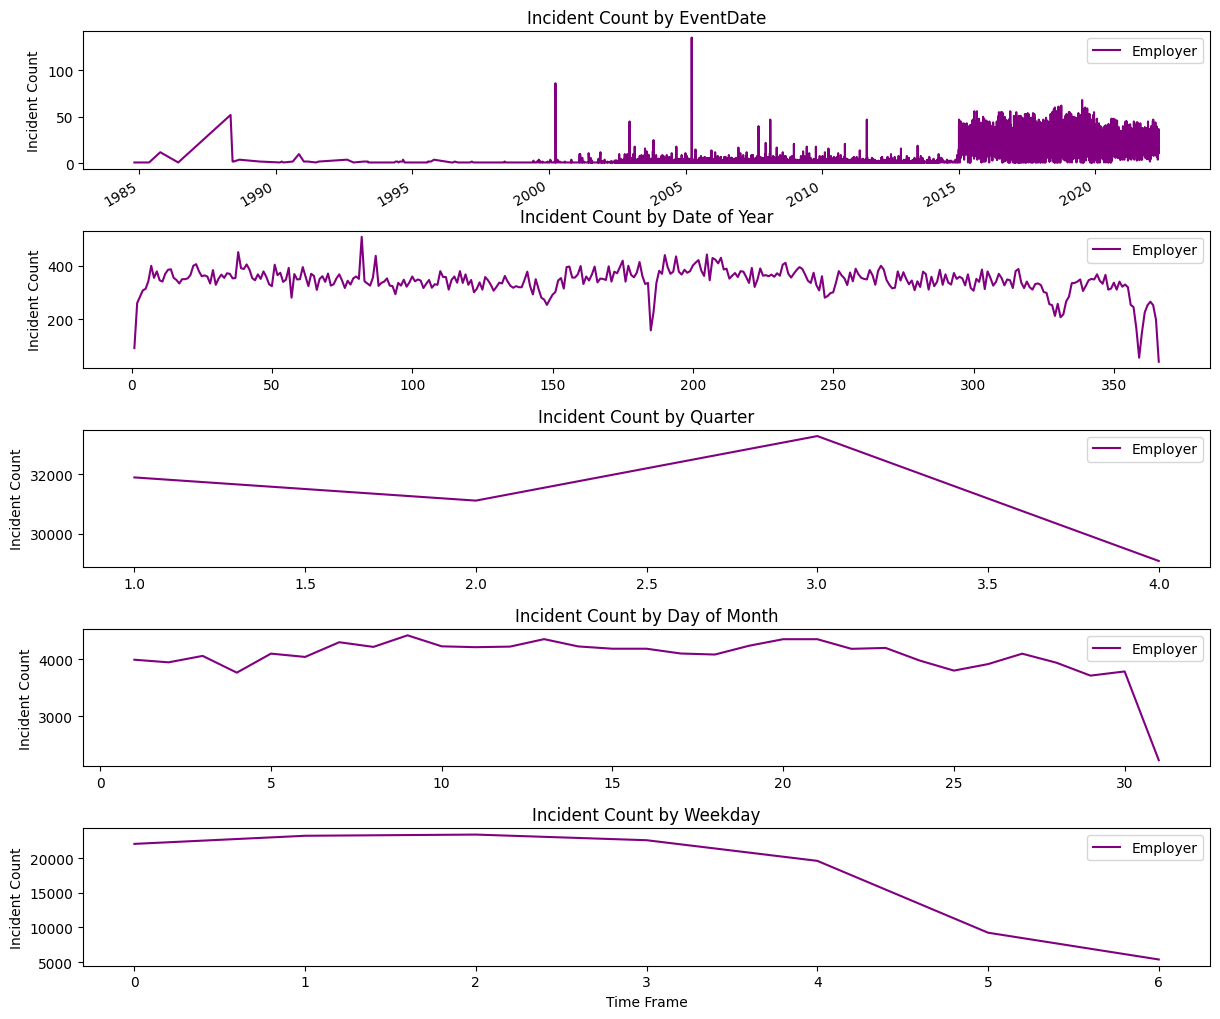

In [8]:
def time_slicer(df, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,10])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,"Employer"]].groupby([x]).count().plot(ax=ax[i],color="purple")
        ax[i].set_ylabel("Incident Count")
        ax[i].set_title("Incident Count by {}".format(x))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    
# Time Frames of Interest
df["Date of Year"] = df['EventDate'].dt.dayofyear # Day of Year
df["Weekday"] = df['EventDate'].dt.weekday 
df["Quarter"] = df['EventDate'].dt.quarter
df["Day of Month"] = df['EventDate'].dt.day

# Plot
time_slicer(df=df,timeframes=["EventDate","Date of Year","Quarter","Day of Month","Weekday"])

In [9]:
# with sns.color_palette("viridis"):
#     f, ax = plt.subplots(1,2, figsize=[10,4],sharey=True)
#     sns.countplot(df["Hospitalized"],ax=ax[0])
#     ax[0].set_title("Distribution of Hospitalized")
#     ax[0].set_ylabel("Count")
#     sns.countplot(df["Amputation"],ax=ax[1])
#     ax[1].set_title("Distribution of Amputation")
#     ax[1].set_ylabel("")
#     plt.tight_layout(pad=0)

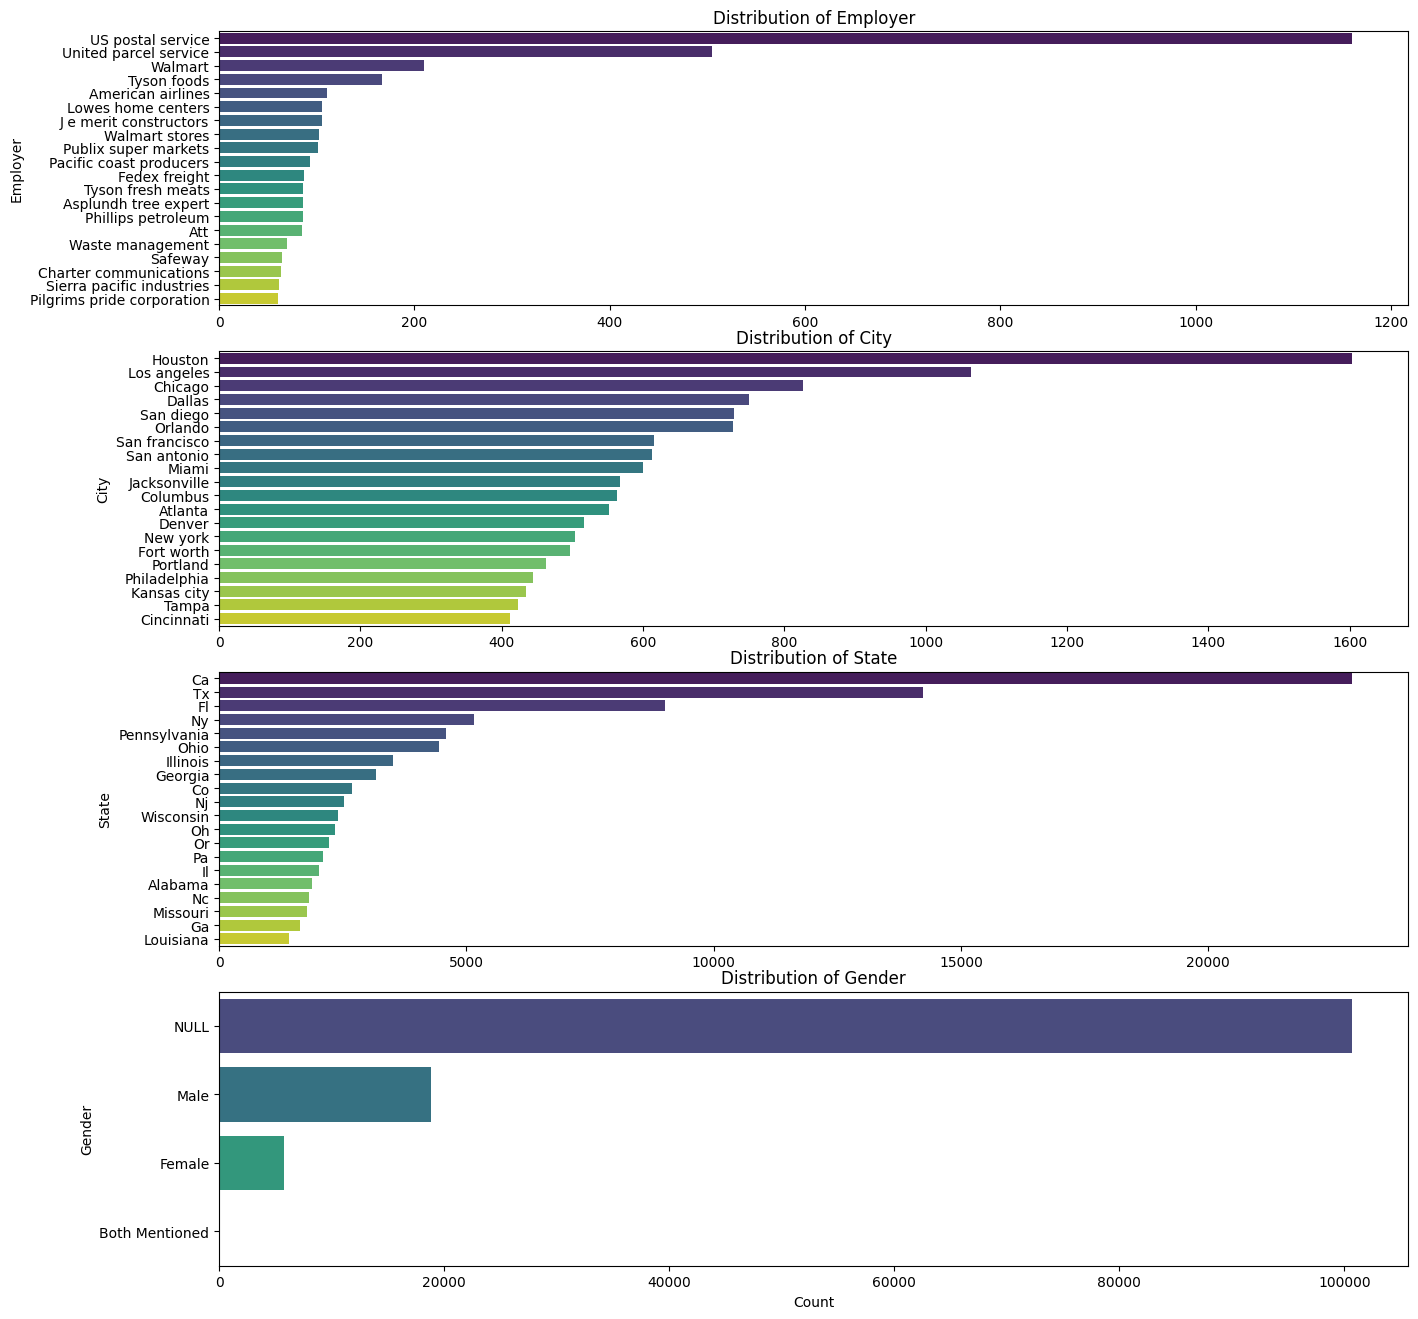

In [10]:
def cat_countplot(df, var, size = [8,10], n=15):
    """
    Function to plot multiple seaborn count plots horizontally, and ordered by most frequent class.
    """
    with sns.color_palette("inferno"):
        f, ax = plt.subplots(len(var),figsize=size)
        for i,x in enumerate(var):
            temptop = df[x].value_counts().index[:n]
            sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax[i],palette='viridis')
            ax[i].set_title("Distribution of {}".format(x))
            ax[i].set_xlabel("")
        ax[len(var)-1].set_xlabel("Count")
        plt.tight_layout(pad=0)

def continous_plots(df, var):
    """
    Built this and found it doesn't apply to my problem at hand.
    """
    f, ax = plt.subplots(1,len(var),figsize=(12,4), sharey=False)
    for i,x in enumerate(var):
        sns.distplot(df[x], ax=ax[i])
        ax[i].set_title("{} Distribution".format(x))
        ax[i].set_ylabel("")
        ax[i].set_xlabel("Distribution")
    ax[0].set_ylabel("Density")
    plt.tight_layout()
    
# Plot
with sns.color_palette("inferno"):
    cat_countplot(df=df, var=["Employer","City","State", "Gender"],n=20, size=[14,13])

**Interpretation:** <br>
Texas and Florida are leaders of pack. Once again, would be best to scale for total laborers before making statements about the risk of these states.

I am quite surprised to find so many incidents occuring at the postal services USPS and UPS. 

Something that must be investigated are the incidents at Walt Disney World.
***
**NatureTitle and Source Title:** <br>

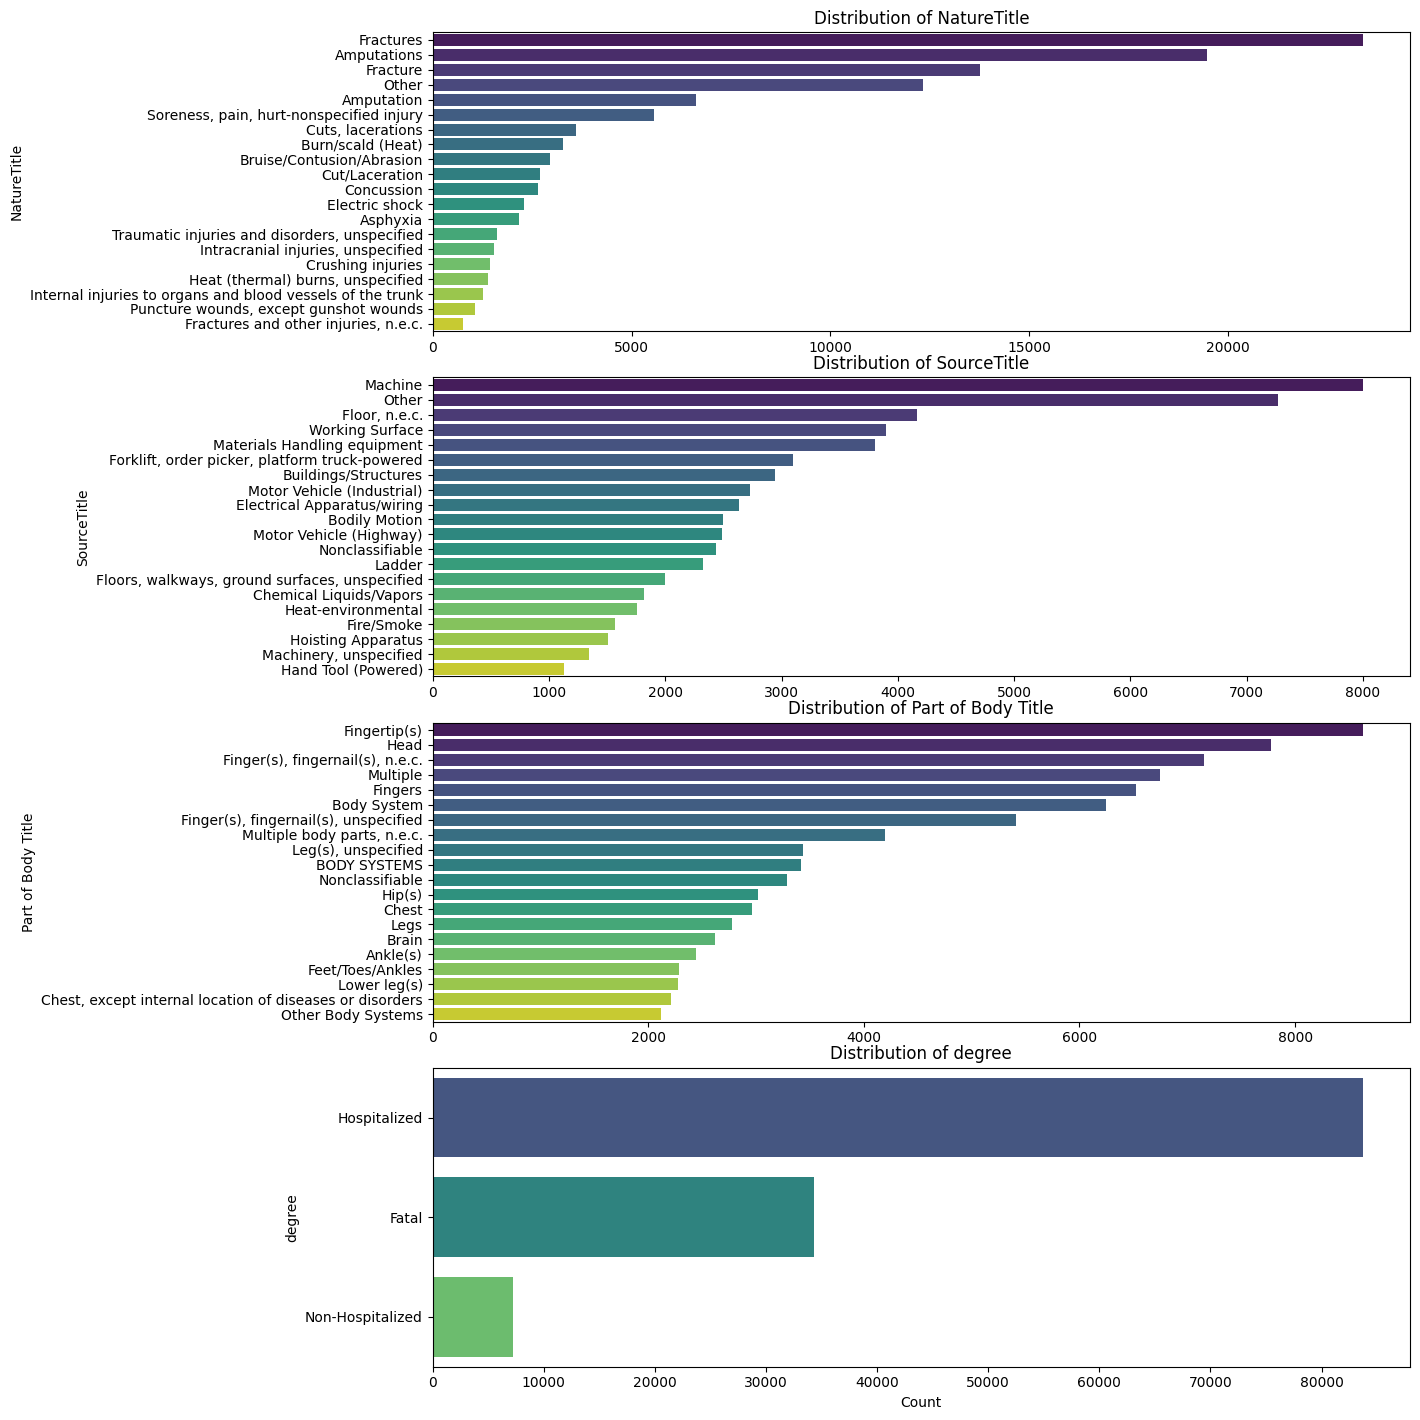

In [11]:
cat_countplot(df=df, var=["NatureTitle","SourceTitle","Part of Body Title","degree"],n=20,size=[14,14])

Need to find a way to consolidate terms like Fracture/Fractures, TX/texas, etc. Might just do this in excel to save frustration. 

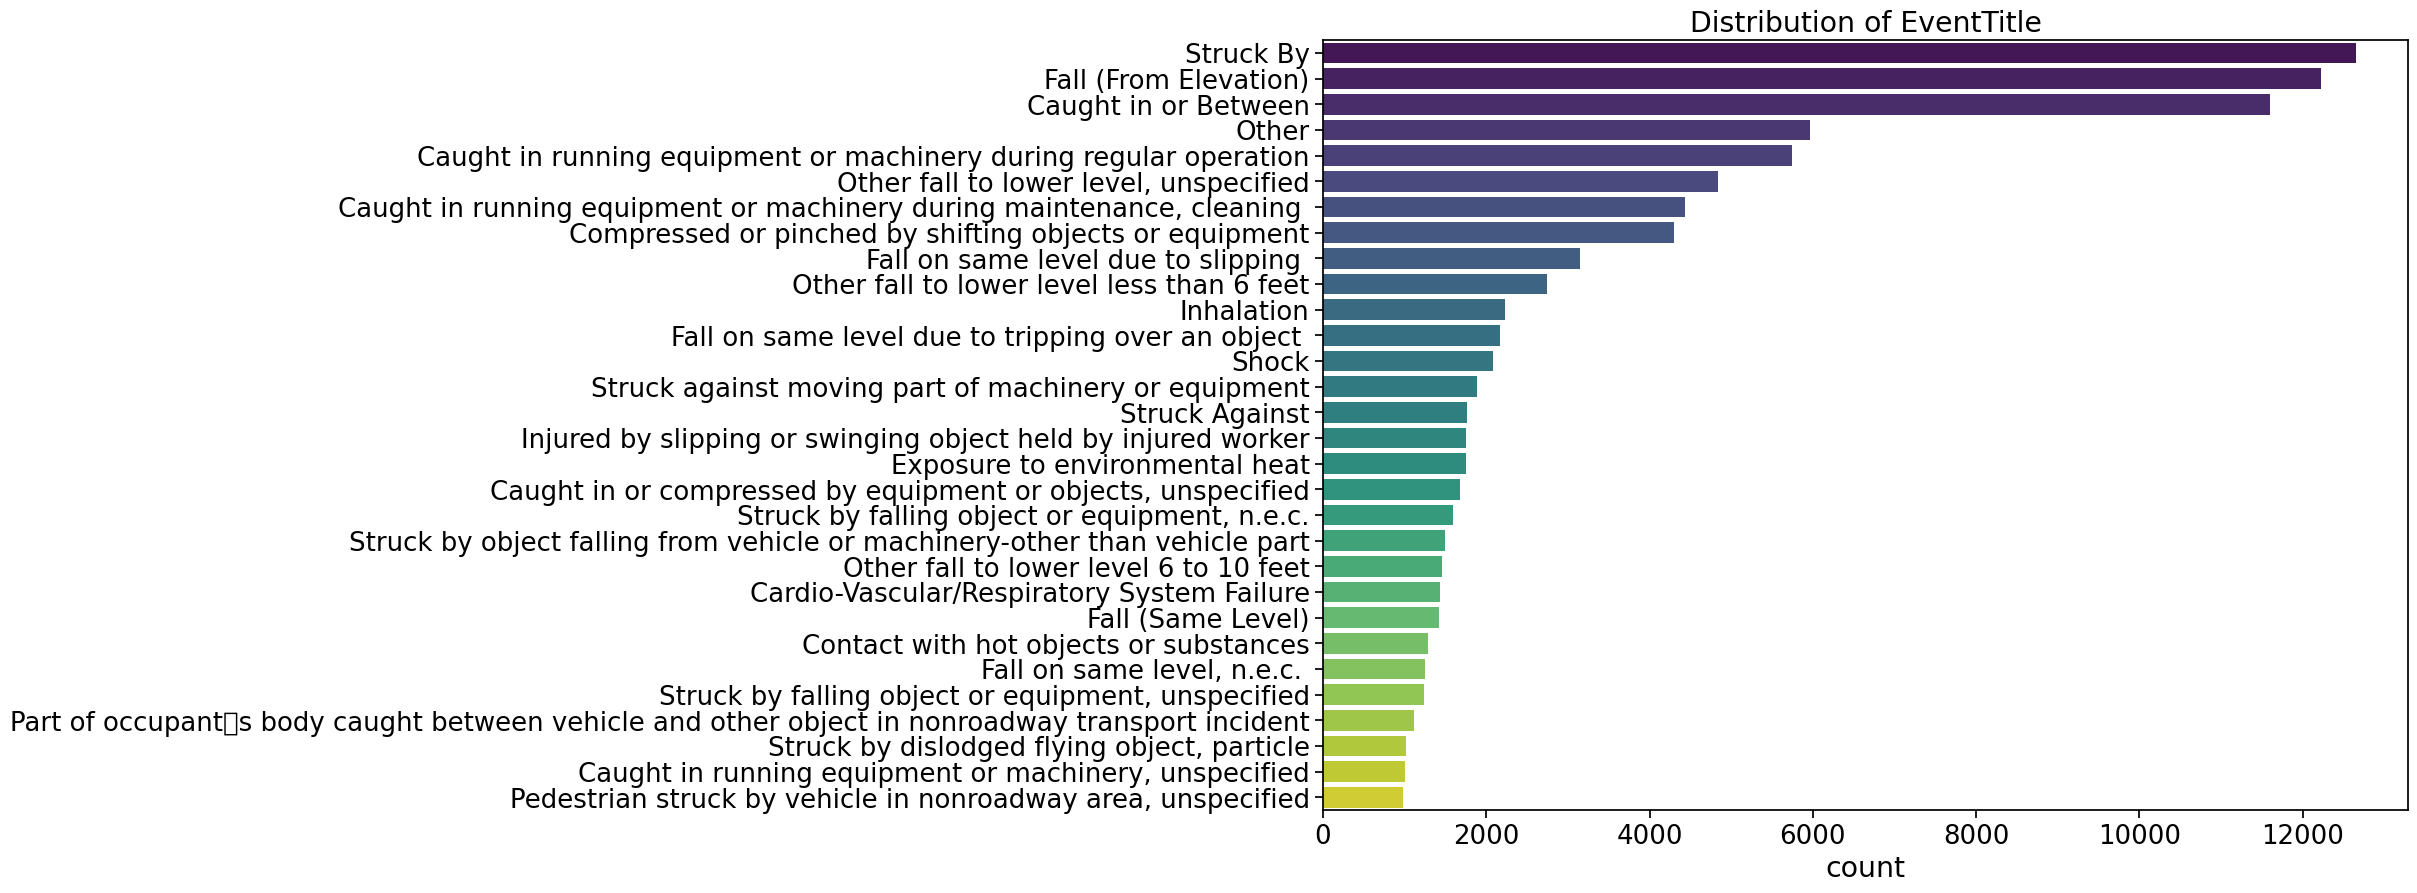

In [12]:
with sns.plotting_context("notebook", font_scale=1.7):
    f, ax = plt.subplots(1,figsize=[14,10])
    x= "EventTitle"
    n=30
    temptop = df[x].value_counts().index[:n]

    sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax, palette="viridis")
    ax.set_title("Distribution of {}".format(x))
    ax.set_ylabel("")
plt.show()

In [13]:
for x in ["EventTitle", "SourceTitle"]:
    print("{} Class Count: {}".format(x,len(set(df[x]))))
    print("{} STD: {}\n".format(x,df[x].value_counts().std()))

EventTitle Class Count: 366
EventTitle STD: 1290.6572878443635

SourceTitle Class Count: 1121
SourceTitle STD: 469.34127177206557



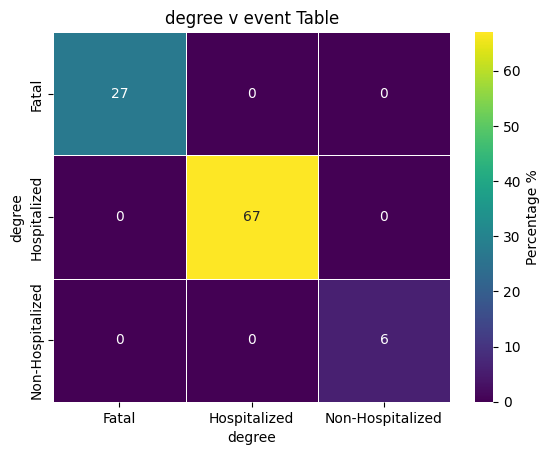

In [14]:
sns.heatmap(pd.crosstab(df['degree'], df["degree"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5,fmt='g', cmap="viridis",
                cbar_kws={'label': 'Percentage %'})
plt.title("degree v event Table")
plt.show()

## TODO: Import collections counter module and use its most common function for this same task but with nature event etc

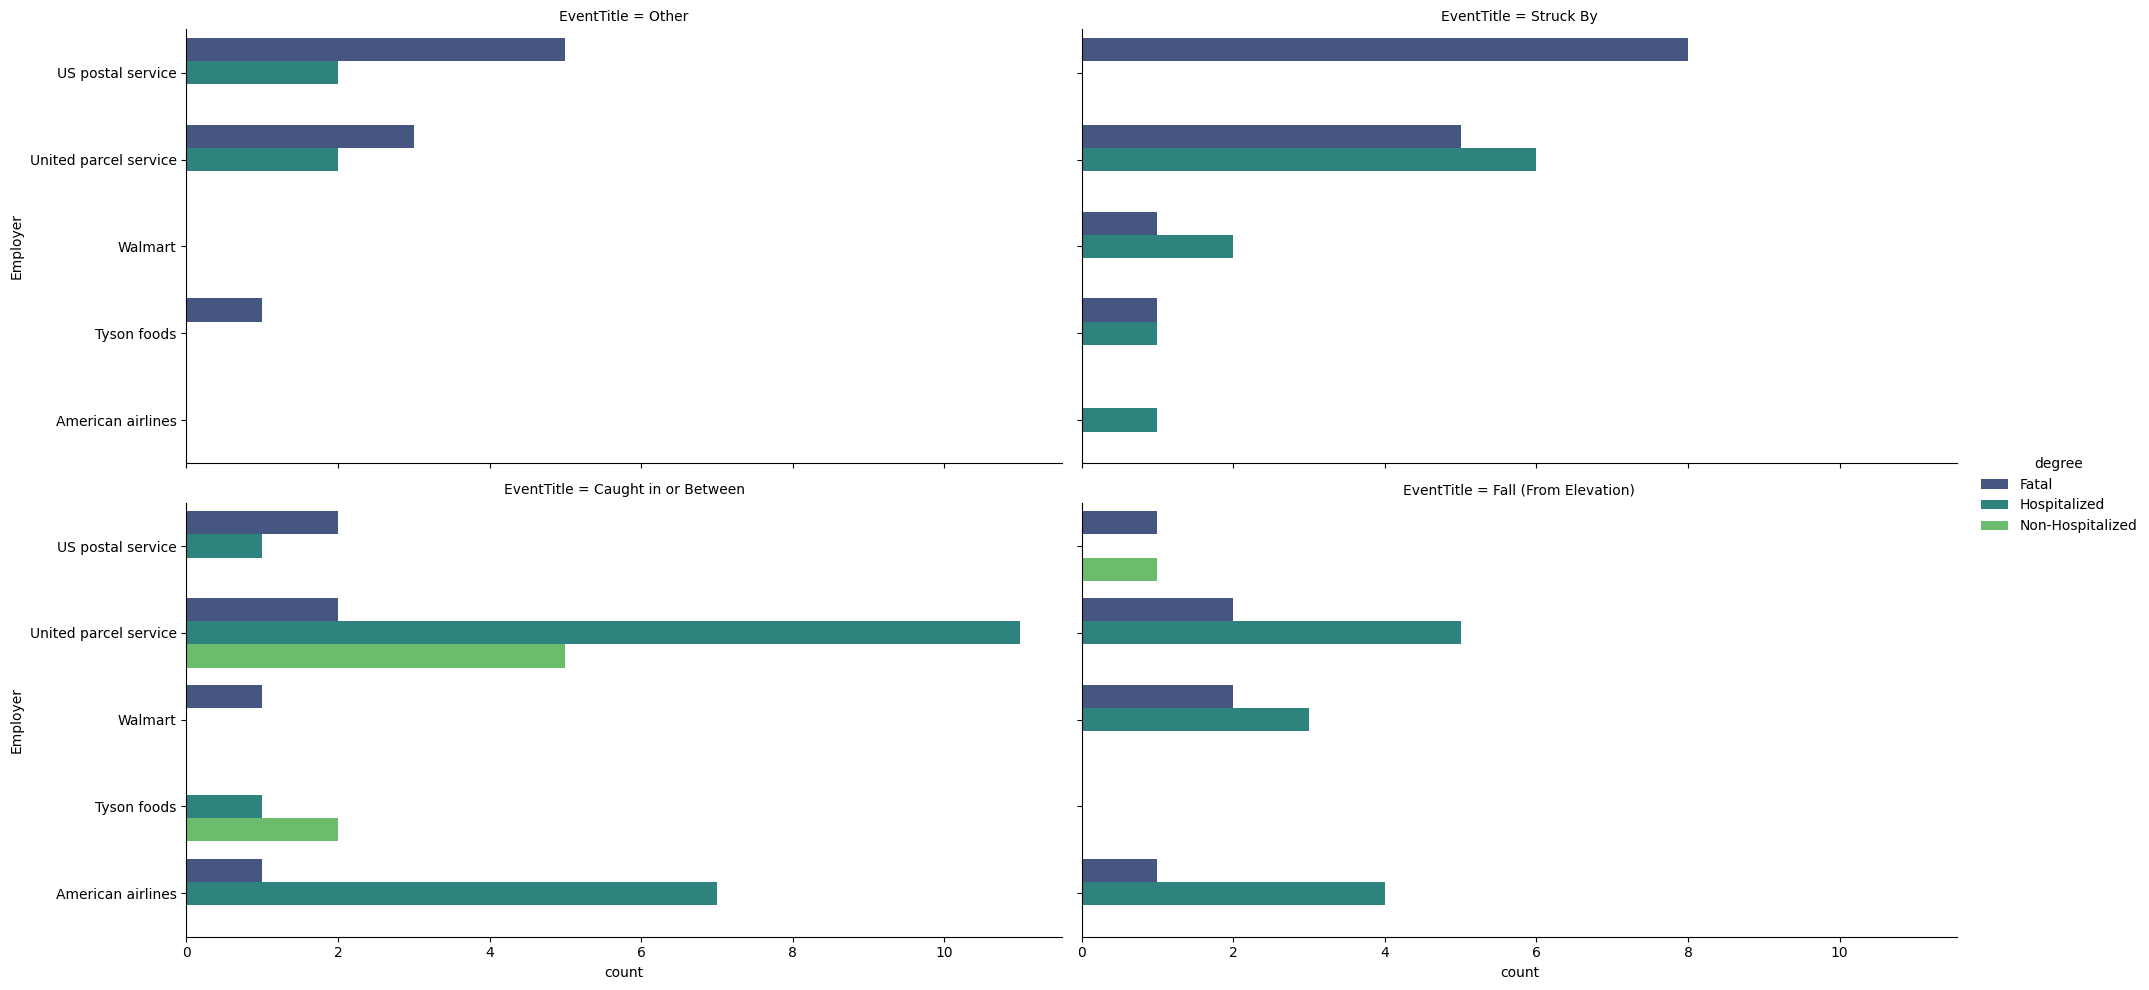

In [15]:
col = "EventTitle"
temp = df.loc[(topcats(df["Employer"]))
              &(topcats(df[col],n=4))
              ,:]
sns.factorplot(y="Employer", hue="degree", col=col, col_wrap=2,
            data=temp, kind="count", palette='viridis',
               order=df["Employer"].value_counts().index[:5],aspect=2)
plt.show()

In [16]:
# def target_rate_by(df, target, by):
#     """
#     So I can look at amputated (target) rate through different lenses (by)
#     """
#     amp_rates = (pd.crosstab(df[by], df[target], normalize = 'index')
#                  .mul(100).round(0).reset_index())
#     amp_rates.columns = [by, "False Rate","Rate"]
#     amp_rates["Count"] = "NaN"
    
#     for x in set(amp_rates[by]):
#         amp_rates.loc[amp_rates[by]==x, "Count"] = df.loc[df[by]==x, by].count()

#     return (amp_rates[[by,"Rate", "Count"]]
#      .sort_values(by="Rate",ascending=False))

# variables = ["EventTitle","SourceTitle","NatureTitle","Part of Body Title",
#              "Employer","State","City","Gender"]
# top = 10
# limit = 7

# # Plot
# f, ax = plt.subplots(len(variables),figsize=[8,25])
# for i,x in enumerate(variables):
#     temp = target_rate_by(df=df, target="Amputated", by=x) # Custom Function
#     sns.barplot(x="Rate",y=x, ax=ax[i],palette='viridis',
#                 data= temp.loc[(temp.Count > limit)][:top])
#     ax[i].set_title("{} Variable".format(x))
#     ax[i].set_xlabel("")
#     ax[i].set_ylabel("")
# ax[len(variables)-1].set_xlabel("Amputation Rate")
# #plt.tight_layout(pad=0)
# plt.subplots_adjust(top=0.95)
# plt.suptitle('Amputation Rate by Categories - Top {} Subclass with Incident Count Over {}'
#              .format(top,limit),fontsize=17)
# plt.show()

In [17]:
def cat_time_slicer(df, slicevar, n, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [11,7])
    top_classes = topcat_index(df[slicevar],n=n)
    for i,x in enumerate(timeframes):
        for y in top_classes:
            total = df.loc[df[slicevar]==y,slicevar].count()
            ((df.loc[(df[slicevar]==y),[x,"Employer"]]
             .groupby([x])
             .count()/total).fillna(0)
            .plot(ax=ax[i], label=y))
        ax[i].set_ylabel("Percent of\nCompany Incidents")
        ax[i].set_title("Percent of Incident by Company by {}".format(x))
        ax[i].set_xlabel("")
        ax[i].legend(top_classes, fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle('Normalized Time-Series for top {} {}s over different over {}'.format(n,slicevar,timeframes),fontsize=17)

**By Employer:** <br>

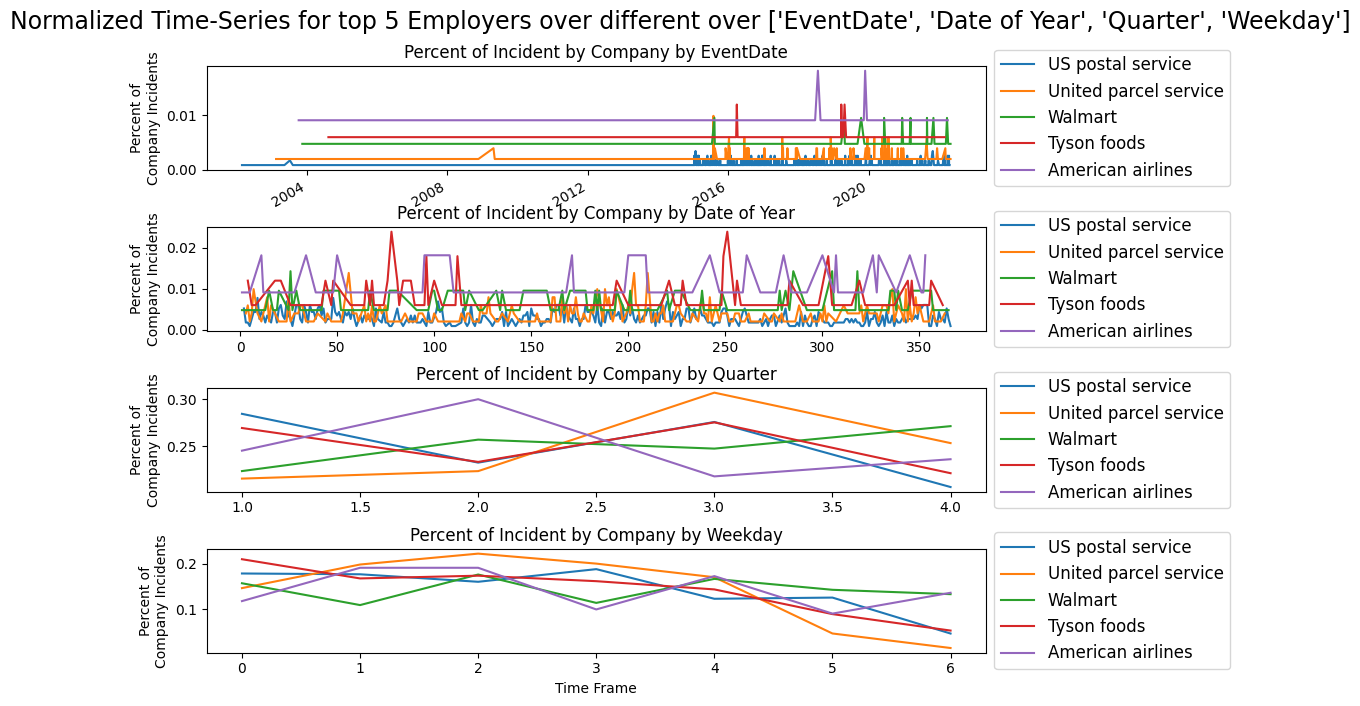

In [18]:
cat_time_slicer(df=df, slicevar = "Employer",
                n=5, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

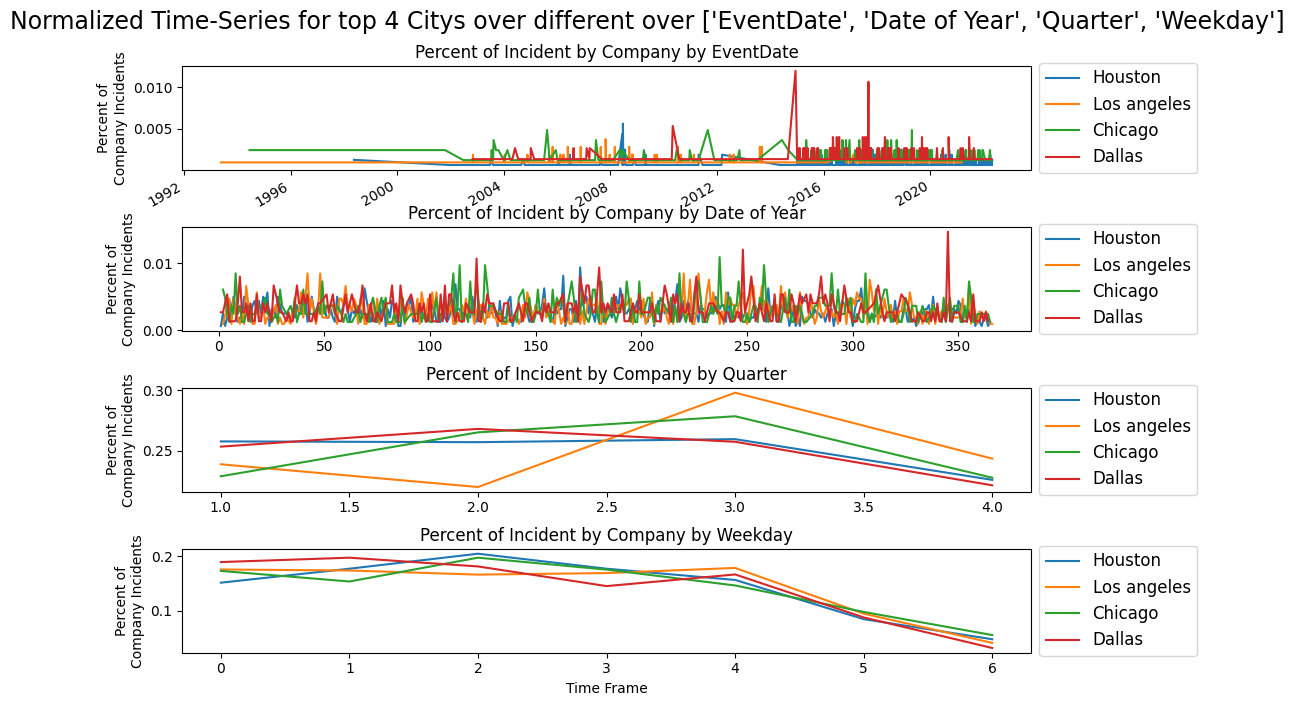

In [19]:
cat_time_slicer(df=df, slicevar = "City",
                n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

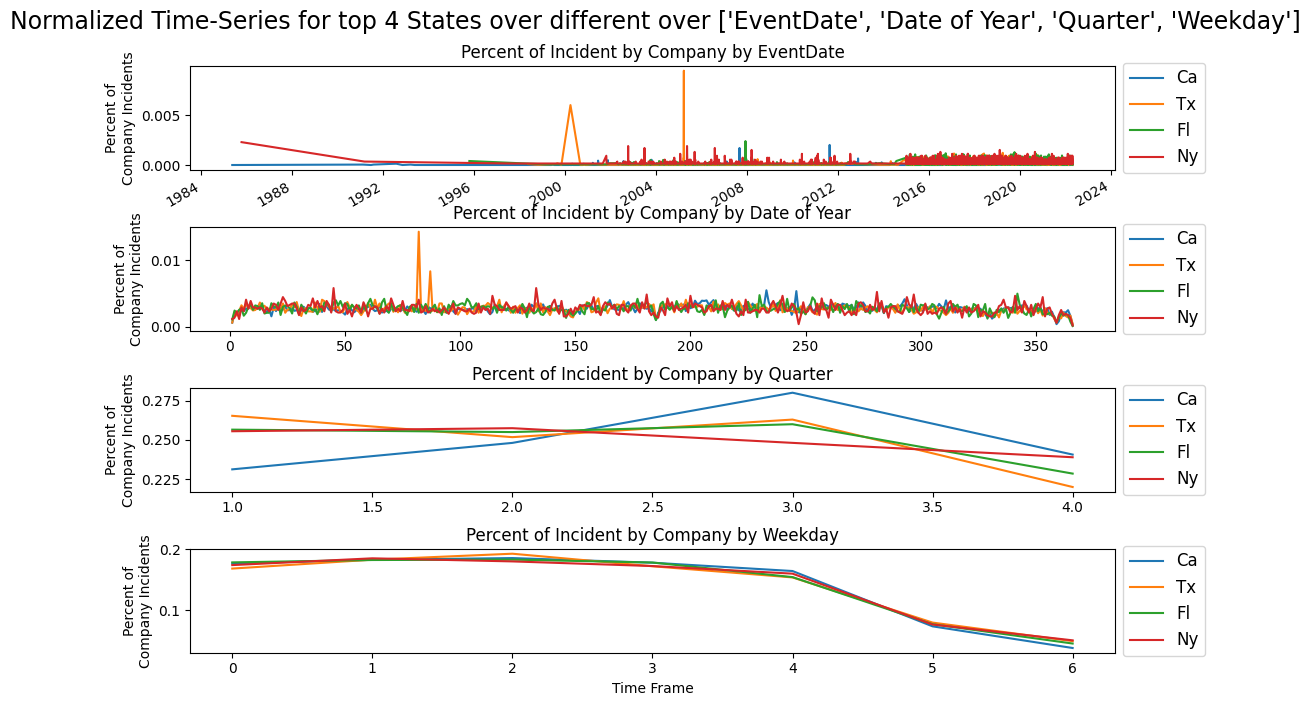

In [20]:
cat_time_slicer(df=df, slicevar = "State",
                n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

**Interpretation:** <br>
More-or-less same behavior over states.

***
**Boolean Amputated:** <br>

In [21]:
# cat_time_slicer(df=df, slicevar = "Amputated",
#                 n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

In [22]:
# cat_time_slicer(df=df[df.Gender != "Both Mentioned"], slicevar = "Gender",
#                 n=5, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

In [23]:
[print("{}\n".format(x)) for x in 
 df["Final Narrative"].loc[
     (df["degree"]=='Fatal') & 
     (df["Final Narrative"]
      .str.contains(r"(?i)gun|(?i)burn|(?i)shock"))]
 .sample(10)]

Employee dies of burns from arc blast electrical fire

Electric Shock - Cause Unknown

Electric Shock - Contact with Overhead Line thru Boom

An employee was lowering a truck after jacking it up to perform an alignment procedure. He placed his right hand between the shock bracket and leaf spring of the truck. When he began to lower the truck, it came down too fast and pinched his finger between the shock bracket and leaf spring. His right index fingertip was amputated.

EMPLOYEE IS BURNED AND KILLED IN EXPLOSION WHILE ON A GENIE

One Employee Dies and Four Burned in Tank Flash Fire

Employees Dies from Second and Third Degree Burns

ELECTRIC SHOCK - DIRECT CONTACT WITH OVERHEAD LINE

Employee burned in gas pipeline fire, later dies

Three Employees Are Burned by Flash Fire, One Later Dies



[None, None, None, None, None, None, None, None, None, None]

## Topic Modeling and Word Clouds

Copied my analysis framework from my [Dark Net Illegal Goods Investigation](https://www.kaggle.com/nicapotato/dark-net-light-in-the-dark)

In [24]:
# Topic Modeling
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS

size = (10,7)
# Function
def cloud(text, title):
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
    wordcloud = WordCloud(width=800, height=400,
                          #background_color='white',
                          #stopwords=stopwords,
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #{}: ".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
    
def LDA(data, name=""):
    # Storing the entire training text in a list
    text = list(data.values)
    # Calling our overwritten Count vectorizer
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                              stop_words='english',
                                              decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)


    lda = LatentDirichletAllocation(n_components=3, max_iter=10,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)
    lda.fit(tf)

    n_top_words = 10
    print("\n{} Topics in LDA model: ".format(name))
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
# Output
pd.set_option('max_colwidth', 700)
pd.set_option('max_info_columns', 100)

def topic_view(catlevel,x,target="Final Narrative",df=df):
    df = df[df[df[catlevel]==x].notnull()]
    print(LDA(df.loc[df[catlevel]==x,target], name=x))
    cloud(df.loc[df[catlevel]==x,target].values,"{}".format(x))

    return df.loc[df[catlevel]==x,[target,"Amputation"]].sample(4)

In [25]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Thomas
[nltk_data]     Tatum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**By Employer:** <br>


Caterpillar Topics in LDA model: 
Topic #0: left machine steel resulting finger hand moving arm amputation plate
Topic #1: finger right amputated forklift left caught foot fingertip core amputation
Topic #2: chain fell step hospitalization engine cart floor 10 second air
None


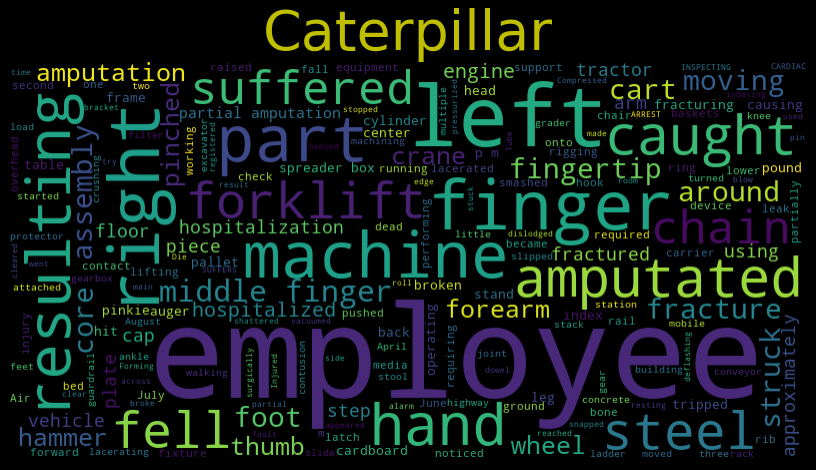

,Final Narrative,Amputation
89562,"On August 15, 2018, an employee was operating a stand-up forklift and turning a corner when the vehicle hit a wet spot and started to slide. The employee released the dead man switch to stop the forklift and then dismounted the vehicle during the slide. His left foot/ankle was struck by the vehicle and a plastic pole protector as the vehicle continued to travel in the direction he exited. He suffered multiple fractures and a puncture wound.",0.0
55393,An employee working on a core machine in the core room had the right pinkie finger amputated as a result of injury. The spreader box stopped indexing across the carrier. The employee went around to the back side of the core machine and noticed that the dowel pin had broke and the back spreader box support wheel was dislodged from the rail and appeared stuck. The employee pushed on the bracket just behind the wheel to try to get the spreader box back on rails and the wheel shattered. The pressurized cylinder snapped forward and caught his pinkie and ring finger on the right hand. The right pinkie finger was surgically amputated.,0.0
90764,"An employee was fitting a skirt to the center core of an upper frame for an excavator when the pneumatic clamp was actuated, making contact with the employee's left thumb and resulting in a fracture and partial amputation of the thumb.",0.0
55606,"An employee was resting his left hand on the edge of a roll-over fixture as he used a 2.5-pound ""dead-blow hammer"" with his right hand to level a cylinder head on the fixture in the salvage drill bed. When he raised the hammer, it struck something above and deflected down onto his left middle finger. He sustained a partial fingertip amputation, losing his fingernail and fleshy fingertip; there was no bone damage.",0.0


In [26]:
topic_view(df=df, catlevel="Employer", x="Caterpillar")


Tyson foods Topics in LDA model: 
Topic #0: finger right left hand machine caught amputated index amputation pallet
Topic #1: truck head suffered burn hospitalization fell requiring degree hook feather
Topic #2: hand time glove water burned maintenance sterilizer belt left finger
None


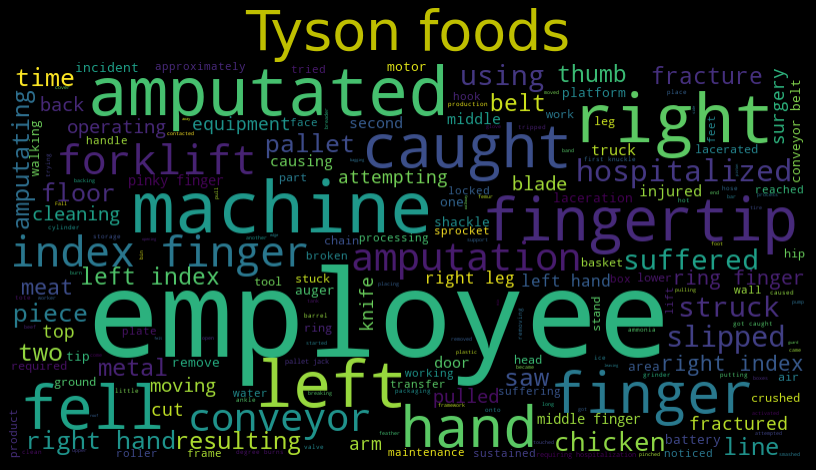

,Final Narrative,Amputation
77590,"An employee was attempting to remove a piece of chicken from a breast processor sawblade when the employee's right hand contacted the blade, amputating the pinky fingertip and lacerating the other fingers.",0.0
96255,An employee was replacing a motor on a platform in the production area. The employee's left hand was on the motor when the chain shifted and pinched the tip of his middle finger between it and the motor causing a fingertip amputation.,0.0
64737,An employee fell and fractured her left femur while walking toward the elevator bank. She was hospitalized.,0.0
78998,"An employee was wiring a low voltage wire gauge to the top of a chemical storage tank when he noticed the overhead light mounting bracket was broken. As he touched the bracket, he received an electrical shock and fell 15 feet off the storage tank, breaking three back vertebrae. He was hospitalized. Fall protection was worn at the time.",0.0


In [27]:
topic_view(df=df, catlevel="Employer", x="Tyson foods")


US postal service Topics in LDA model: 
Topic #0: employee fell mail right delivering left broken slipped head vehicle
Topic #1: employee mail heat hospitalized delivering route related dehydration illness stress
Topic #2: employee finger door right amputated hand caught fingertip amputation left
None


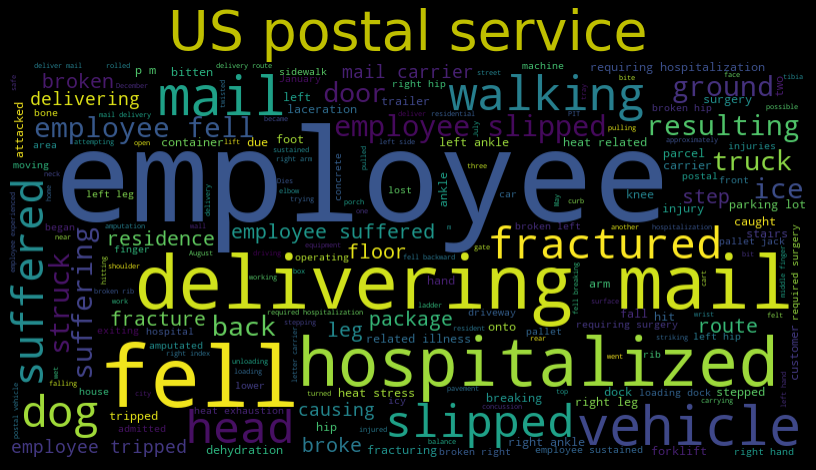

,Final Narrative,Amputation
62568,An employee was hospitalized after falling.,0.0
122699,"Before 2:00 p.m. on January 18, 2022, a rural mail carrier was walking down a hill, back to their vehicle. The employee slipped and fell on icy ground and suffered a broken lower left leg. The employee was hospitalized, undergoing surgery.",0.0
71737,"An employee was delivering parcels when he slipped on black ice, breaking his lower right leg and right ankle in two places.",0.0
58200,An employee was struck by truck at the loading dock resulting in a broken pelvis.,0.0


In [28]:
topic_view(df=df, catlevel="Employer", x="US postal service")


Walmart Topics in LDA model: 
Topic #0: pallet fell right suffered foot broken hospitalized floor cart hip
Topic #1: finger amputated left vehicle amputation machine injured belt oil breaking
Topic #2: fell floor hip head ladder broken suffering cart tripped ground
None


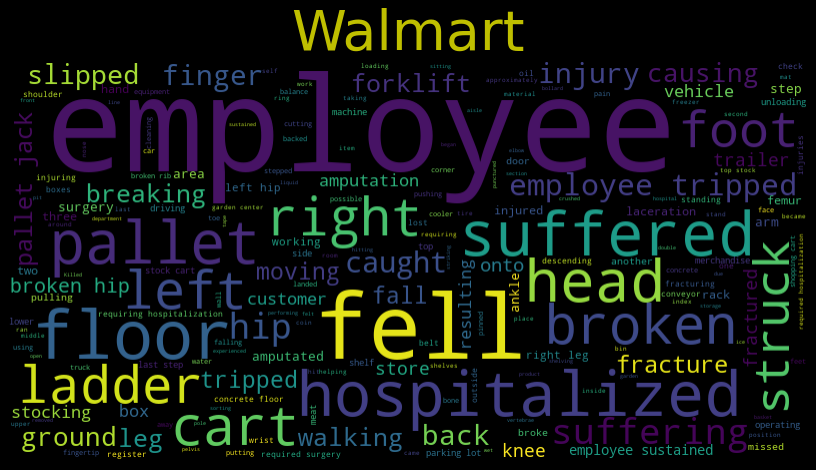

,Final Narrative,Amputation
119399,"Three employees were emptying a full container of trash into an outside dumpster. As they were lifting the container over the edge of the dumpster, it came down and caught one employee's right hand against the dumpster's edge. The employee's middle and ring fingertips were amputated, including the nails.",0.0
70544,"An employee was moving a box of fabric when she lost her balance and fell, fracturing her left femur.",0.0
82386,"An employee was on a ladder cutting wrapping from product when the employee fell to the floor, suffering a fracture and requiring hospitalization.",0.0
121334,An employee was stocking produce when she tripped over plastic wrap hanging from a pallet and fell to the floor. The employee was hospitalized for a broken hip.,0.0


In [29]:
topic_view(df=df, catlevel="Employer", x="Walmart")

***
**By Gender:** <br>


Male Topics in LDA model: 
Topic #0: finger hand left right machine caught amputation fingertip middle amputated
Topic #1: fell foot ground ladder broken hospitalized head floor left truck
Topic #2: hospitalized forklift pallet suffered burn leg left jack truck struck
None


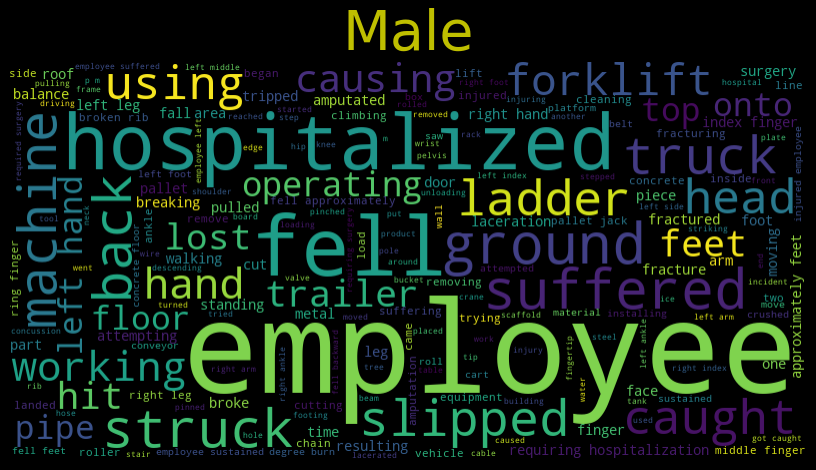

,Final Narrative,Amputation
85221,"An employee was operating a crane and connecting a jib to the main boom when the jib unhooked from the boom, causing it to strike his head and shoulder. He broke his sternum and L-3 vertebra.",0.0
97373,An electric pallet jack operator was pulling a load of boxes when he was struck by a stand-up forklift and sustained a crushing injury to the right tibia.,0.0
77029,"An employee was on an extension ladder (approximately 8 feet up) testing a phone port on the ceiling when the ladder slipped out from under him and he fell to the ground, breaking his vertebrae and crushing a disc in his lower back. He was hospitalized.",0.0
89726,"An employee was adjusting the cover on an LED light when he contacted a live wire and was shocked, suffering electrical burns that required hospitalization. Gloves were not worn at the time of the incident.",0.0


In [30]:
topic_view(df=df, catlevel="Gender", x="Male")


Female Topics in LDA model: 
Topic #0: finger machine hand right caught left fingertip amputated amputation index
Topic #1: fell floor walking right tripped left slipped hip hospitalized breaking
Topic #2: head hospitalized foot fell suffered pallet leg struck left hit
None


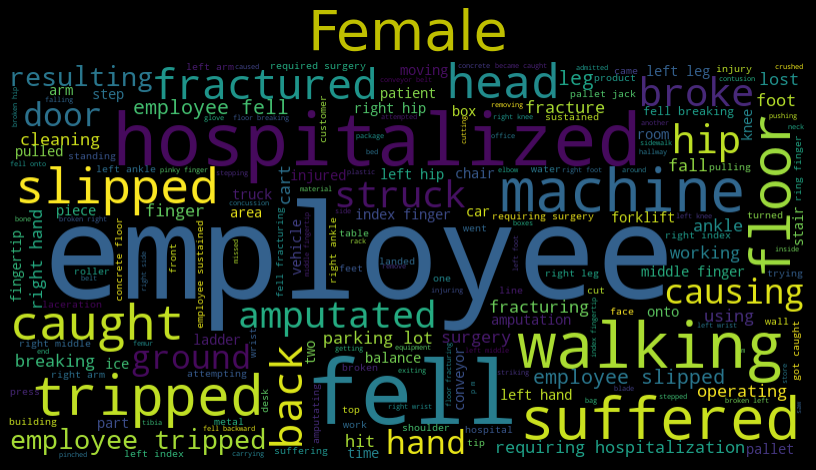

,Final Narrative,Amputation
83755,An employee was retrieving her purse to go home. A plastic liner was sticking out from an empty yarn cage and the employee tripped over the plastic liner and fell fracturing her left femur and patella.,0.0
73558,An employee was working at her desk when she got up and tripped over her sneaker. She then hit her head on a nurse's station and broke her wrist on the floor. She was hospitalized.,0.0
123416,"A temporary employee was working on a shredder machine when a piece of material got stuck in the bottom of the belt on the machine. She was trying to retrieve the stuck material when the material grabbed her hand and it pulled it into the machine. Her finger wrapped around the material, and the machine amputated an inch of her left middle finger.",0.0
91955,An employee was operating a microtome machine when it activated. Its blade cut off the tip of her finger.,0.0


In [31]:
topic_view(df=df, catlevel="Gender", x="Female")

***
**By Body Part Affected:**


Brain Topics in LDA model: 
Topic #0: head struck truck hospitalized causing injury concussion suffered trailer hit
Topic #1: lift head struck platform unconscious concussion metal knocked hose hospitalized
Topic #2: head fell injury floor hospitalized ground foot ladder suffering concussion
None


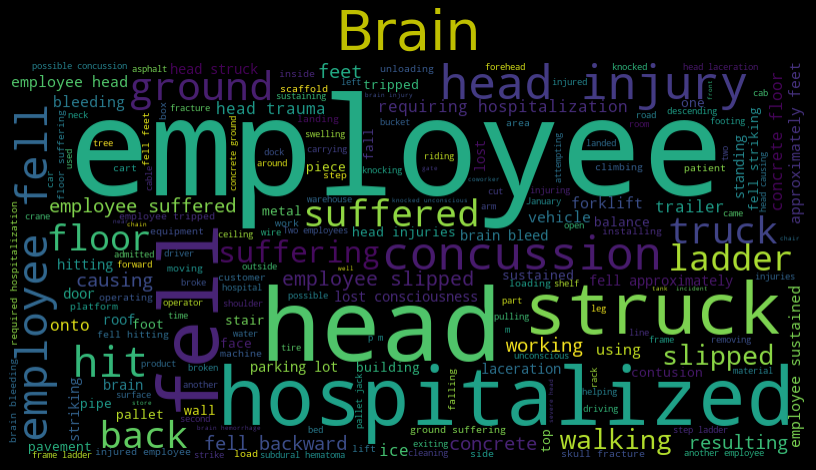

,Final Narrative,Amputation
54340,An employee was struck on the top of the head by a piece of debris.,0.0
69545,"An employee tripped over an extension cord and struck her head on a stretcher, suffering a concussion.",0.0
116989,Two employees were involved in horseplay while walking when one employee fell and struck their head on the concrete floor resulting in a concussion.,0.0
62179,"A maintenance employee was pulling antenna cables while standing on a 6-foot A-frame ladder when he slipped and fell to the ground below, sustaining a head injury.",0.0


In [32]:
topic_view(df=df, catlevel="Part of Body Title", x="Brain")